In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
A_MAX = 1.0
A_MIN = -1.0
DAYS = 7
PERIOD = 24*DAYS
START=0

In [33]:
df_kpi = pd.read_csv('default SAC 500 norm space results\KPIs.csv',
                     usecols=['cost_function','uACG_binary_SAC_05_eps','untargeted_binary_myPGD_5%_mask_time'],
                     index_col=0)

myPGD outperformed ACG despite being a weaker attack, and this is also true for the discrete agent

In [34]:
df_kpi['untargeted_binary_myPGD_5%_mask_time'] - df_kpi['uACG_binary_SAC_05_eps']

cost_function
annual_peak_average                      0.139875
carbon_emissions_total                   0.103341
cost_total                               0.143066
daily_one_minus_load_factor_average     -0.001525
daily_peak_average                       0.357603
electricity_consumption_total            0.084954
monthly_one_minus_load_factor_average    0.006936
ramping_average                          0.099346
zero_net_energy                          0.002881
dtype: float64

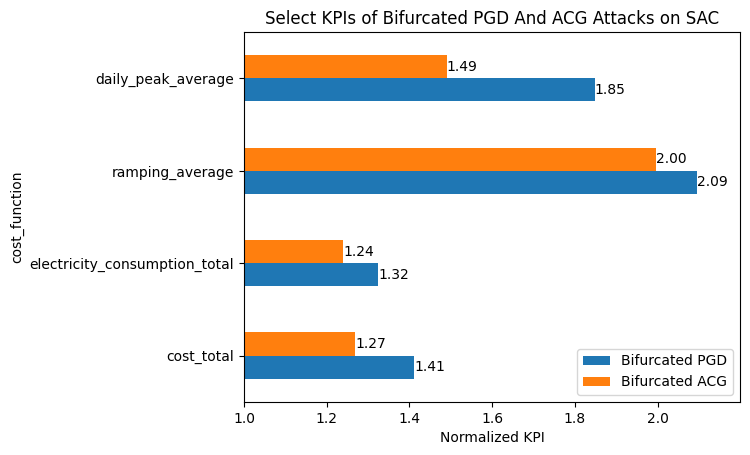

In [35]:
kpi_to_plot = ['cost_total', 'electricity_consumption_total','ramping_average','daily_peak_average']
ax = df_kpi[['untargeted_binary_myPGD_5%_mask_time','uACG_binary_SAC_05_eps']].loc[kpi_to_plot].plot.barh(
                  ylabel='KPI',
                  title='Select KPIs of Bifurcated PGD And ACG Attacks on SAC',
                  xlim=1.0,
                  )
ax.set_xlabel('Normalized KPI')
ax.legend(['Bifurcated PGD', 'Bifurcated ACG'],
          #bbox_to_anchor=(1.0, 0.6),
          )
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')

In [36]:
df_a = pd.DataFrame({})
df_a['myPGD_clean_actions'] = pd.read_csv(r'default SAC 500 norm space results\untargeted_binary_myPGD_5%_mask_time_obs-a.csv',
            usecols=['a'])
df_a['myPGD_adv_actions'] = pd.read_csv(r'default SAC 500 norm space results\untargeted_binary_myPGD_5%_mask_time_adv_obs-a.csv',
            usecols=['a'])
df_a['ACG_clean_actions'] = pd.read_csv(r'default SAC 500 norm space results\uACG_binary_SAC_05_eps a-obs.csv',
            usecols=['a'])
df_a['ACG_adv_actions'] = pd.read_csv(r'default SAC 500 norm space results\uACG_binary_SAC_05_eps adv a-obs.csv',
            usecols=['a'])


Transform action space [0,1] -> [-1,1]

In [37]:
df_a = df_a*2 -1

Stats:

In [38]:
print(f'The ASR for the myPGD attack is {format((df_a["myPGD_clean_actions"] != df_a["myPGD_adv_actions"]).mean(), ".3f")}')
print(f'The ASR for the ACG attack is {format((df_a["ACG_clean_actions"] != df_a["ACG_adv_actions"]).mean(), ".3f")}')

The ASR for the myPGD attack is 1.000
The ASR for the ACG attack is 1.000


In [39]:
myPGD_decision_flip = (np.sign(df_a['myPGD_clean_actions']) != np.sign(df_a['myPGD_adv_actions'])).mean()
ACG_decision_flip = (np.sign(df_a['ACG_clean_actions']) != np.sign(df_a['ACG_adv_actions'])).mean()
print(f'The (dis)charge was reversed {format(myPGD_decision_flip, ".3f")} of the time for the myPGD attack, \
       compared to {format(ACG_decision_flip, ".3f")} for ACG. ACG was {format(ACG_decision_flip/myPGD_decision_flip, ".3f")} times as effective')


The (dis)charge was reversed 0.922 of the time for the myPGD attack,        compared to 0.920 for ACG. ACG was 0.998 times as effective


In [40]:
myPGD_sign_flip_from_prev = (np.sign(df_a['myPGD_adv_actions']) != np.sign(df_a['myPGD_adv_actions'].shift())).mean()
myPGD_sign_flip_from_prev = (np.sign(df_a['ACG_adv_actions']) != np.sign(df_a['ACG_adv_actions'].shift())).mean()
print(f'The (dis)charge was reversed between two timesteps {format(myPGD_sign_flip_from_prev, ".3f")} of the time for the myPGD attack, \
       compared to {format(myPGD_sign_flip_from_prev, ".3f")} for ACG. ACG was {format(myPGD_sign_flip_from_prev/myPGD_sign_flip_from_prev, ".3f")} times as effective')

The (dis)charge was reversed between two timesteps 0.205 of the time for the myPGD attack,        compared to 0.205 for ACG. ACG was 1.000 times as effective


In [41]:
print(f'MAE for transformed discrete myPGD attack:{format((df_a["myPGD_clean_actions"] - df_a["myPGD_adv_actions"]).abs().mean(), ".3f")}')
print(f'MAE for transformed ACG attack actions:{format((df_a["ACG_clean_actions"] - df_a["ACG_adv_actions"]).abs().mean(), ".3f")}')

MAE for transformed discrete myPGD attack:0.862
MAE for transformed ACG attack actions:0.568


ACG outperforms myPGD on all the metrics above. It seems to adhere best to the GDL surrogate loss function, which may indicate this loss function is sub-optimal. If the effect is reproduced for the discrete agent, this is the likely cause

In [42]:
myPGD_mask = df_a.columns[df_a.columns.str.contains('myPGD')]
ACG_mask = df_a.columns[df_a.columns.str.contains('ACG')]

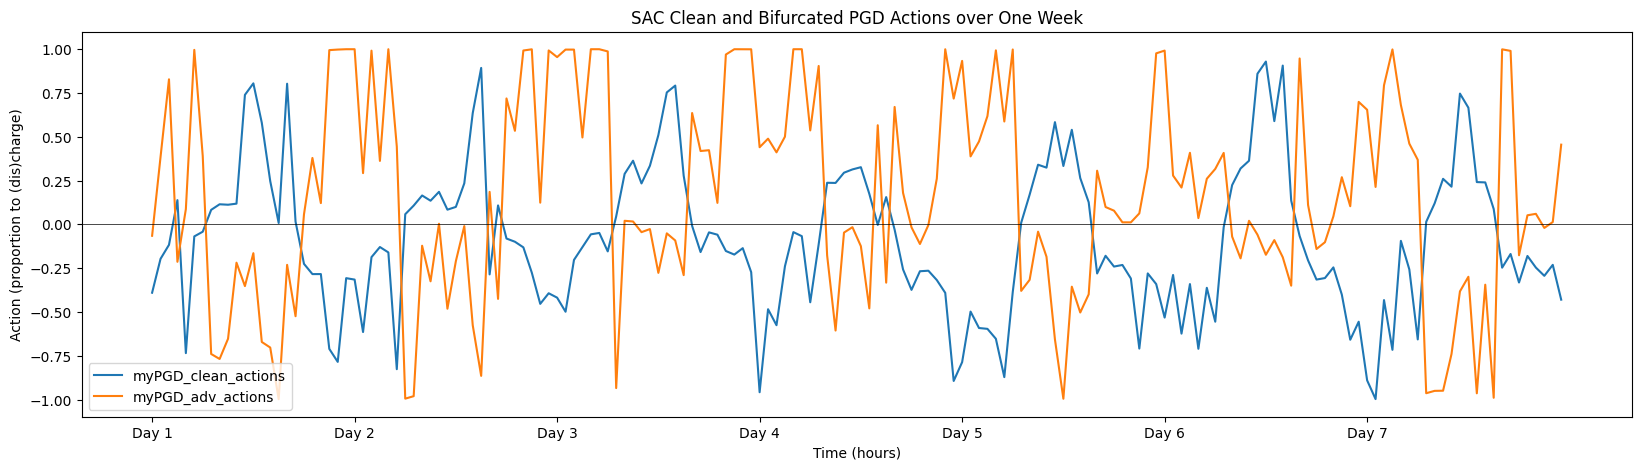

In [43]:
start = 0*7*24
df_a[myPGD_mask].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='SAC Clean and Bifurcated PGD Actions over One Week',
    xlabel='Time (hours)',
    ).set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
plt.axhline(0, color='black', linewidth=0.5)

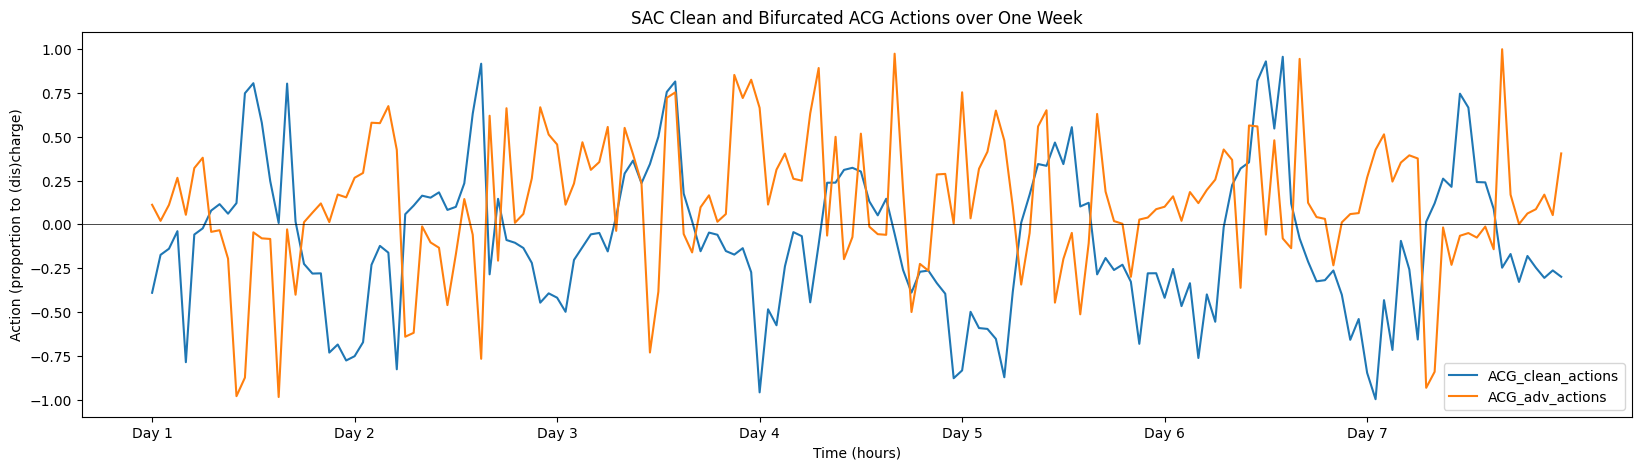

In [44]:
start = 0*7*24
df_a[ACG_mask].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='SAC Clean and Bifurcated ACG Actions over One Week',
    xlabel='Time (hours)'
    ).set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
plt.axhline(0, color='black', linewidth=0.5)

Is ACG finding points closer to where x == -x, and that's why the actions look even more mirrored than my PGD? 

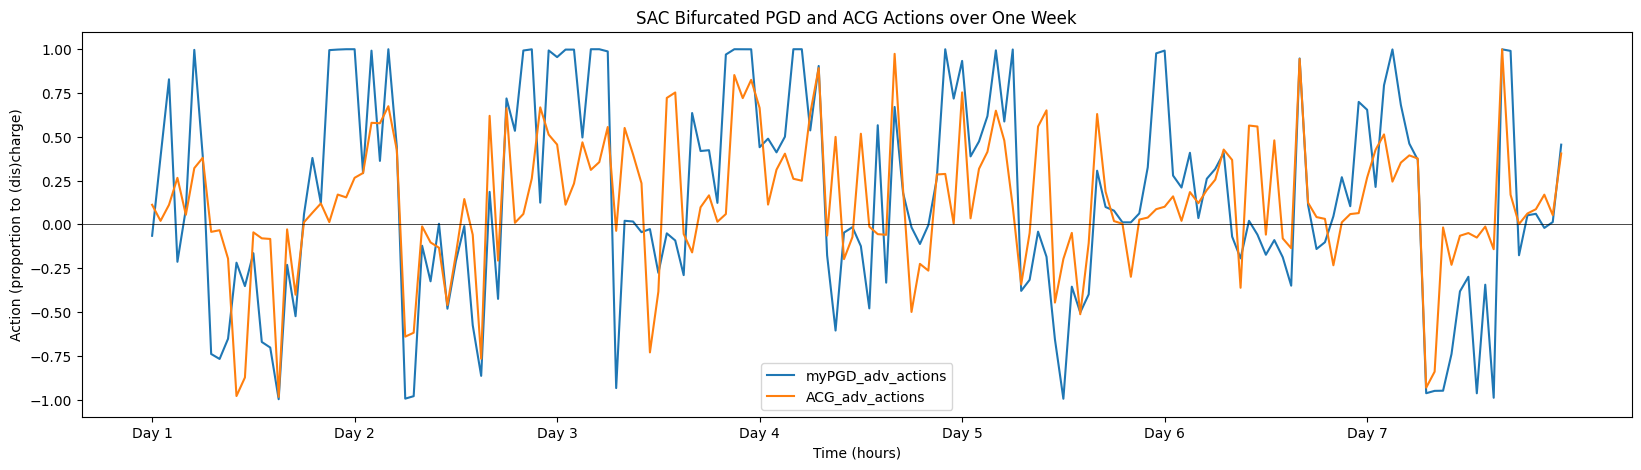

In [45]:
start = 0*7*24
df_a[['myPGD_adv_actions','ACG_adv_actions']].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='SAC Bifurcated PGD and ACG Actions over One Week',
    xlabel='Time (hours)'
    ).set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
plt.axhline(0, color='black', linewidth=0.5)

From this plot (during this week), myPGD fully charges then fully discharges more than ACG. Maybe this is why it uses more power? Can I take the integral/sum of the actions to check?

Text(0.5, 0, '(Dis)charge Action')

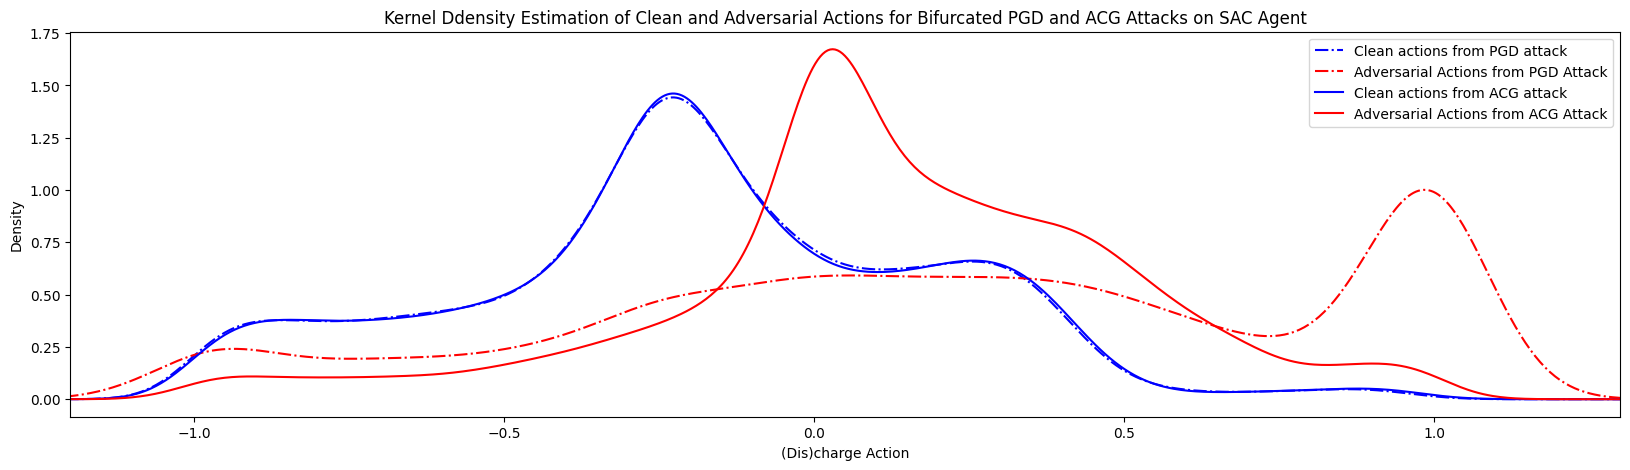

In [46]:
ax = df_a.plot.kde(
    figsize=(20,5),
    xlim=(-1.2,1.3),
    xlabel='(Dis)harge Action',
    title='Kernel Ddensity Estimation of Clean and Adversarial Actions for Bifurcated PGD and ACG Attacks on SAC Agent',
    style=['b-.','r-.','b-','r-'],
)
ax.legend(['Clean actions from PGD attack', 'Adversarial Actions from PGD Attack','Clean actions from ACG attack', 'Adversarial Actions from ACG Attack'])
ax.set_xlabel('(Dis)charge Action')

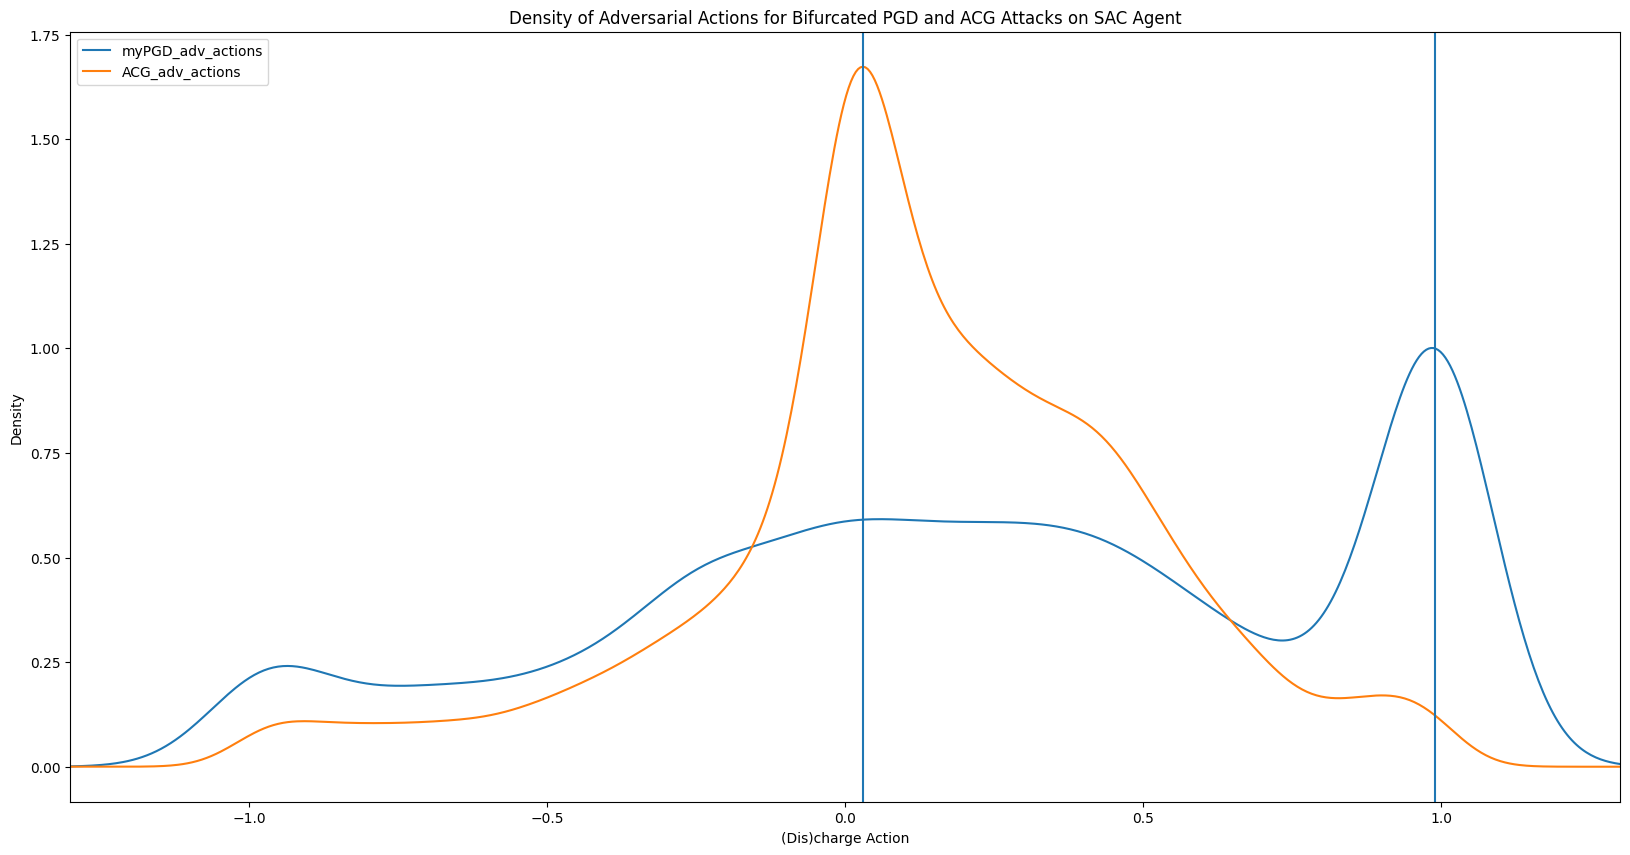

In [47]:
ax = df_a[['myPGD_adv_actions','ACG_adv_actions']].plot.kde(
    figsize=(20,10),
    xlim=(-1.3,1.3),
    xlabel='(Dis)harge Action',
    title='Density of Adversarial Actions for Bifurcated PGD and ACG Attacks on SAC Agent'
)
ax.set_xlabel('(Dis)charge Action')
plt.axvline(0.99)
plt.axvline(0.03)

Overall, we see very different distirbutions between the attacks, which explains the different KPIs. The surrogate loss function provided by the bifurcation layer may not be optimal, given that the weaker attack performed best.

In [48]:
df_a[['myPGD_adv_actions','ACG_adv_actions']].mean()

myPGD_adv_actions    0.243770
ACG_adv_actions      0.128587
dtype: float64

myPGD is biased towards discraging from the mean, whereas ACG is much closer to a no action with a slight bias towards charging. FUrthermore, we see that myPGD does fully charge occaisionally

In [49]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] > 0.9).mean()

myPGD_adv_actions    0.237242
ACG_adv_actions      0.020664
dtype: float64

In [50]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] < -0.9).mean()

myPGD_adv_actions    0.049663
ACG_adv_actions      0.014499
dtype: float64

In [51]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] < 0).describe()

,myPGD_adv_actions,ACG_adv_actions
count,8759,8759
unique,2,2
top,False,False
freq,5721,6222


In [52]:
df_a[['myPGD_adv_actions','ACG_adv_actions']][df_a[['myPGD_adv_actions','ACG_adv_actions']] < 0].describe()

,myPGD_adv_actions,ACG_adv_actions
count,3038.000000,2537.000000
mean,-0.421640,-0.285416
std,0.319200,0.276056
min,-1.000000,-0.999935
25%,-0.686887,-0.429462
50%,-0.323098,-0.192193
75%,-0.152252,-0.061037
max,-0.000075,-0.000053


In [53]:
df_a[['myPGD_adv_actions','ACG_adv_actions']][df_a[['myPGD_adv_actions','ACG_adv_actions']] > 0].describe()

,myPGD_adv_actions,ACG_adv_actions
count,5721.000000,6222.000000
mean,0.597120,0.297395
std,0.351467,0.248098
min,0.000314,0.000024
25%,0.276302,0.082174
50%,0.580049,0.245712
75%,0.997199,0.452402
max,1.000000,0.999952
